<a href="https://colab.research.google.com/github/wkssm18/data_analysis_study/blob/main/toronto_airbnb_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [106]:
# Install all necessary packages
!pip install geopandas
!pip install shapely

In [107]:
# Import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon
import re

Data is retrieved from this website: https://insideairbnb.com/get-the-data/

In [108]:
# Load all files
listings = pd.read_csv('/content/drive/MyDrive/statistics and R/Toronto airbnb data/listings.csv')
neighbourhoods_json = gpd.read_file('/content/drive/MyDrive/statistics and R/Toronto airbnb data/neighbourhoods.geojson')

In [109]:
# Check the listings file
listings.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,1419,Home in Toronto · ★5.0 · 5 bedrooms · 7 beds ·...,1565,Alexandra,NaN,Little Portugal,43.64590,-79.42423,Entire home/apt,NaN,28,6,2017-08-07,0.06,1,0,0,NaN
1,8077,Rental unit in Toronto · ★4.84 · 1 bedroom · 1...,22795,Kathie & Larry,NaN,Waterfront Communities-The Island,43.64080,-79.37673,Private room,100.0,180,169,2013-08-27,0.96,2,0,0,NaN
2,26654,Condo in Toronto · ★4.79 · 1 bedroom · 2 beds ...,113345,Adela,NaN,Waterfront Communities-The Island,43.64608,-79.39032,Entire home/apt,145.0,28,42,2023-09-01,0.27,5,77,2,NaN
3,27423,Rental unit in Toronto · ★4.93 · Studio · 1 be...,118124,Brent,NaN,South Riverdale,43.66884,-79.32725,Entire home/apt,75.0,90,28,2023-08-31,0.17,1,215,1,NaN
4,30931,Rental unit in Toronto · 1 bedroom · 2 beds · ...,22795,Kathie & Larry,NaN,Waterfront Communities-The Island,43.64015,-79.37625,Entire home/apt,134.0,180,1,2010-08-11,0.01,2,0,0,NaN


In [110]:
# Check the neighbourhoods json file
neighbourhoods_json.head()

,neighbourhood,neighbourhood_group,geometry
0,York University Heights,None,"MULTIPOLYGON (((-79.50529 43.75987, -79.50488 ..."
1,The Beaches,None,"MULTIPOLYGON (((-79.31485 43.66674, -79.31356 ..."
2,Scarborough Village,None,"MULTIPOLYGON (((-79.21397 43.72676, -79.21400 ..."
3,South Parkdale,None,"MULTIPOLYGON (((-79.42777 43.62979, -79.42948 ..."
4,South Riverdale,None,"MULTIPOLYGON (((-79.32868 43.64745, -79.32867 ..."


### Data cleaning
- Delete unnecessary column(s)

In [111]:
# Check any null values
listings.isnull().sum().sort_values(ascending = False).head(10)

,0
neighbourhood_group,20386
license,10930
reviews_per_month,5258
last_review,5258
price,3791
host_name,2
neighbourhood,0
latitude,0
longitude,0
room_type,0


In [112]:
# The column 'neighbourhood_group contains no values. It is the same for both dataframes
# Therefore, delete those columns from both dataframes
listings.drop('neighbourhood_group', axis = 1, inplace = True)
neighbourhoods_json.drop('neighbourhood_group', axis = 1, inplace = True)

### Feature engineering
- Generate geometry data using latitude and longitude
- Extract number of bedrooms, number of bathrooms, and rating information from 'name' column

In [113]:
# Create a new dataframe with converted geometry data that can be used in GeoPandas
# Latitude and Longitude data are not needed anymore so will delete those columns after
geometry = [Point(xy) for xy in zip(listings['longitude'], listings['latitude'])]
geo_df = gpd.GeoDataFrame(listings, crs = 'epsg:4326', geometry = geometry)
geo_df.drop(['latitude', 'longitude'], axis = 1, inplace = True)

In [114]:
# Creating functions that extracts number of bedrooms and bathrooms
def extract_bedrooms_from_list(lst):
    for item in lst:
        # Check if the item contains the word "Studio"
        if 'studio' in item.lower():
            return 0
        # Check if the item contains the word "bedroom" or "bedrooms"
        elif 'bedroom' in item.lower():
            # Use regex to extract the number preceding "bedroom" or "bedrooms"
            match = re.search(r'(\d+)\s*bedroom', item.lower())
            if match:
                return int(match.group(1))
    # Return None or a default value if no bedrooms info is found
    return None

def extract_baths_from_list(lst):
    total_baths = 0
    for item in lst:
        # Check if the item contains the word "bath"
        if 'bath' in item.lower():
            # Check for shared bath and adjust count accordingly
            if 'shared' in item.lower():
                match = re.search(r'(\d+(\.\d+)?)\s*shared\s*bath', item.lower())
                if match:
                    total_baths += 0.5 * float(match.group(1))
                else:
                    total_baths += 0.5
            else:
                # Use regex to extract the number preceding "bath" (e.g., "1.5 baths", "1 private bath")
                match = re.search(r'(\d+(\.\d+)?)\s*(private\s*)?bath', item.lower())
                if match:
                    total_baths += float(match.group(1))
                else:
                    total_baths += 1
    return total_baths

In [115]:
# Creating features of number of bedrooms and bathrooms and adding them as new columns
bedroom_counts = [extract_bedrooms_from_list(lst) for lst in geo_df['name'].str.split('·')]
bathrooms_counts = [extract_baths_from_list(lst) for lst in geo_df['name'].str.split('·')]
geo_df['bathrooms'] = bathrooms_counts
geo_df['bedrooms'] = bedroom_counts
geo_df['ratings'] = geo_df['name'].str.extract(r'★(\d+\.\d+)').astype(float)

In [116]:
# Check the finalized dataframe
geo_df.head()

,id,name,host_id,host_name,neighbourhood,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license,geometry,bathrooms,bedrooms,ratings
0,1419,Home in Toronto · ★5.0 · 5 bedrooms · 7 beds ·...,1565,Alexandra,Little Portugal,Entire home/apt,NaN,28,6,2017-08-07,0.06,1,0,0,NaN,POINT (-79.42423 43.64590),3.0,5.0,5.00
1,8077,Rental unit in Toronto · ★4.84 · 1 bedroom · 1...,22795,Kathie & Larry,Waterfront Communities-The Island,Private room,100.0,180,169,2013-08-27,0.96,2,0,0,NaN,POINT (-79.37673 43.64080),1.5,1.0,4.84
2,26654,Condo in Toronto · ★4.79 · 1 bedroom · 2 beds ...,113345,Adela,Waterfront Communities-The Island,Entire home/apt,145.0,28,42,2023-09-01,0.27,5,77,2,NaN,POINT (-79.39032 43.64608),1.0,1.0,4.79
3,27423,Rental unit in Toronto · ★4.93 · Studio · 1 be...,118124,Brent,South Riverdale,Entire home/apt,75.0,90,28,2023-08-31,0.17,1,215,1,NaN,POINT (-79.32725 43.66884),1.0,0.0,4.93
4,30931,Rental unit in Toronto · 1 bedroom · 2 beds · ...,22795,Kathie & Larry,Waterfront Communities-The Island,Entire home/apt,134.0,180,1,2010-08-11,0.01,2,0,0,NaN,POINT (-79.37625 43.64015),1.5,1.0,NaN


Text(0.5, 1.0, 'All Listings in Toronto')

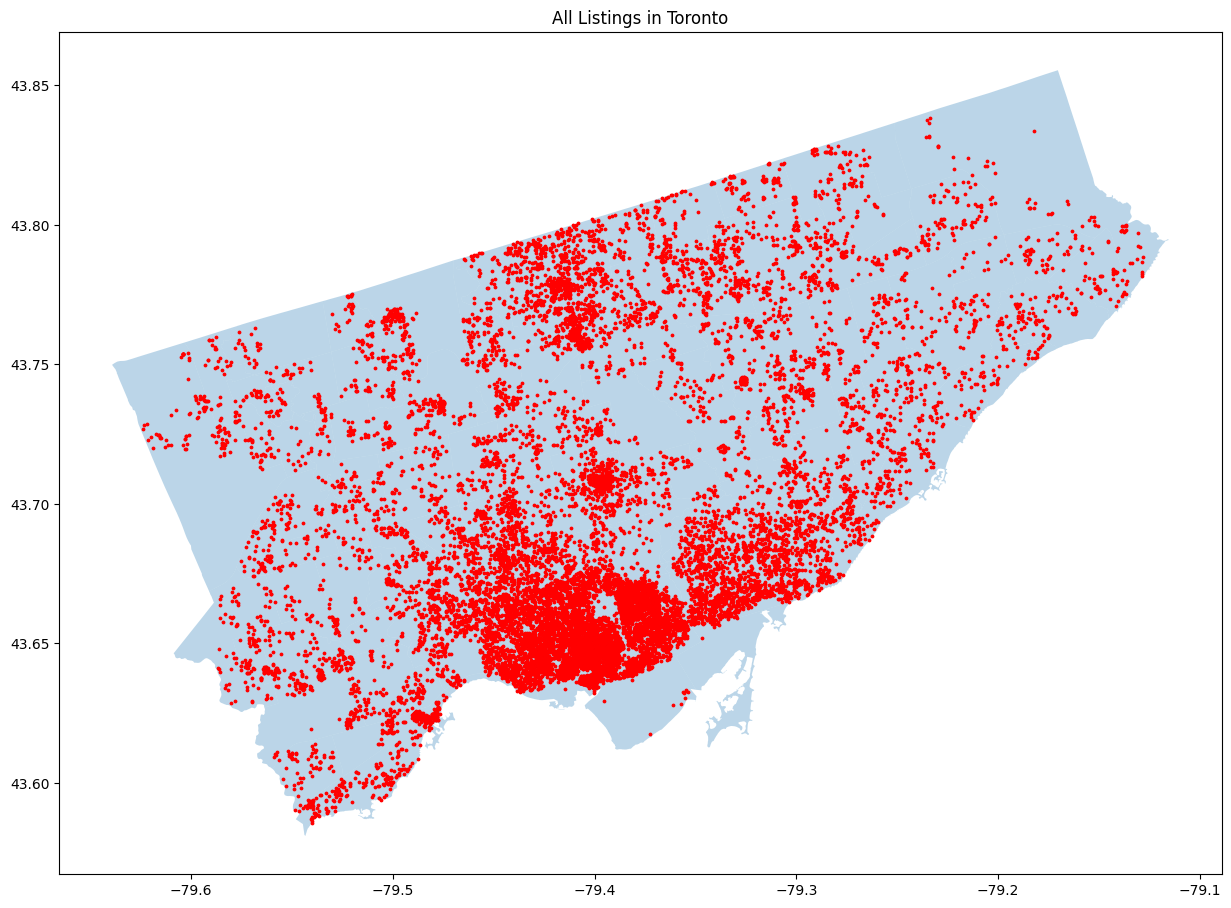

In [117]:
# Plot all the listings
fig, ax = plt.subplots(figsize = (15, 15))
neighbourhoods_json.plot(ax = ax, alpha = 0.3)
geo_df.plot(ax = ax, color = 'red', markersize = 3)
plt.title('All Listings in Toronto')

Text(0, 0.5, 'Number of Listings')

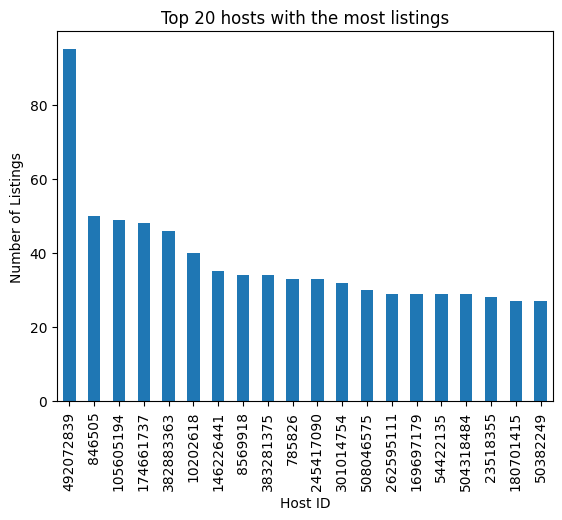

In [118]:
# Graph the top 20 hosts with the most listings
geo_df.groupby('host_id')['id'].count().sort_values(ascending = False).head(20).plot(kind = 'bar')
plt.title('Top 20 hosts with the most listings')
plt.xlabel('Host ID')
plt.ylabel('Number of Listings')

Text(0.5, 1.0, 'All listings by host_id 492072839')

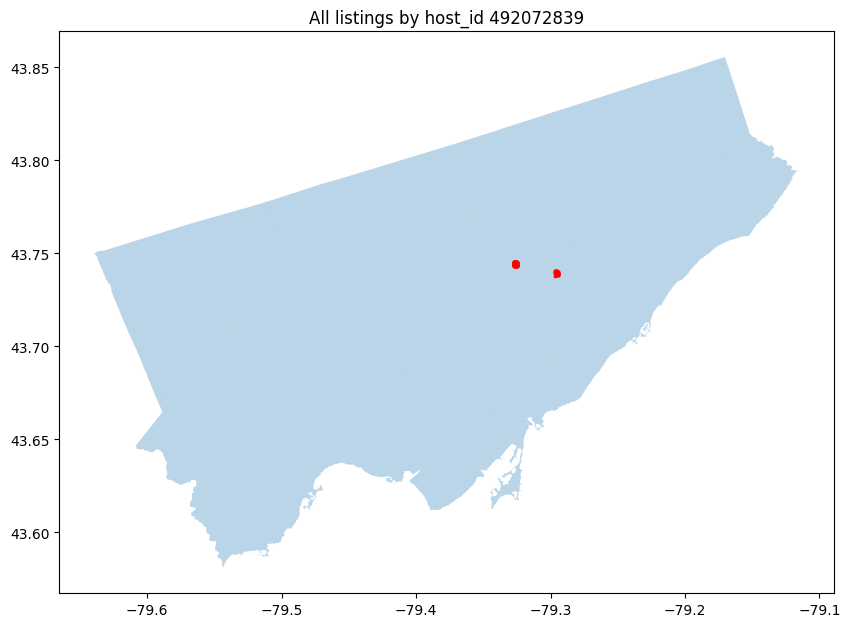

In [119]:
# Let's see all the listings by the host with the most listings
host_with_most_listings = 492072839
fig, ax = plt.subplots(figsize = (10, 10))
neighbourhoods_json.plot(ax = ax, alpha = 0.3)
geo_df[geo_df['host_id'] == host_with_most_listings].plot(ax = ax, color = 'red', markersize = 3)
plt.title(f'All listings by host_id {host_with_most_listings}')

In [120]:
# Filter out the listings with no price information, then find the basic statistical data about the price
geo_df[~geo_df['price'].isnull()]['price'].describe()

,price
count,16595.000000
mean,177.039168
std,333.108977
min,8.000000
25%,75.000000
50%,120.000000
75%,195.000000
max,12400.000000


Text(0.5, 1.0, 'Listings with top 10% of the price')

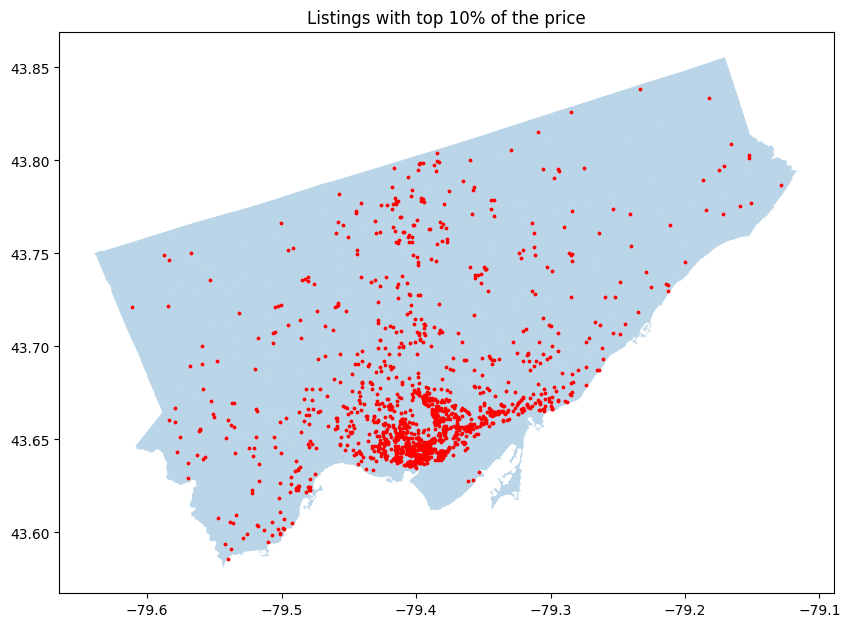

In [133]:
# Show all listings with the top 10% of the price
quantile = 0.9
fig, ax = plt.subplots(figsize = (10, 10))
neighbourhoods_json.plot(ax = ax, alpha = 0.3)
geo_df[geo_df['price'] > geo_df['price'].quantile(quantile)].plot(ax = ax, color = 'red', markersize = 3)
plt.title('Listings with top 10% of the price')

Text(0.5, 1.0, 'Top 5 listed regions')

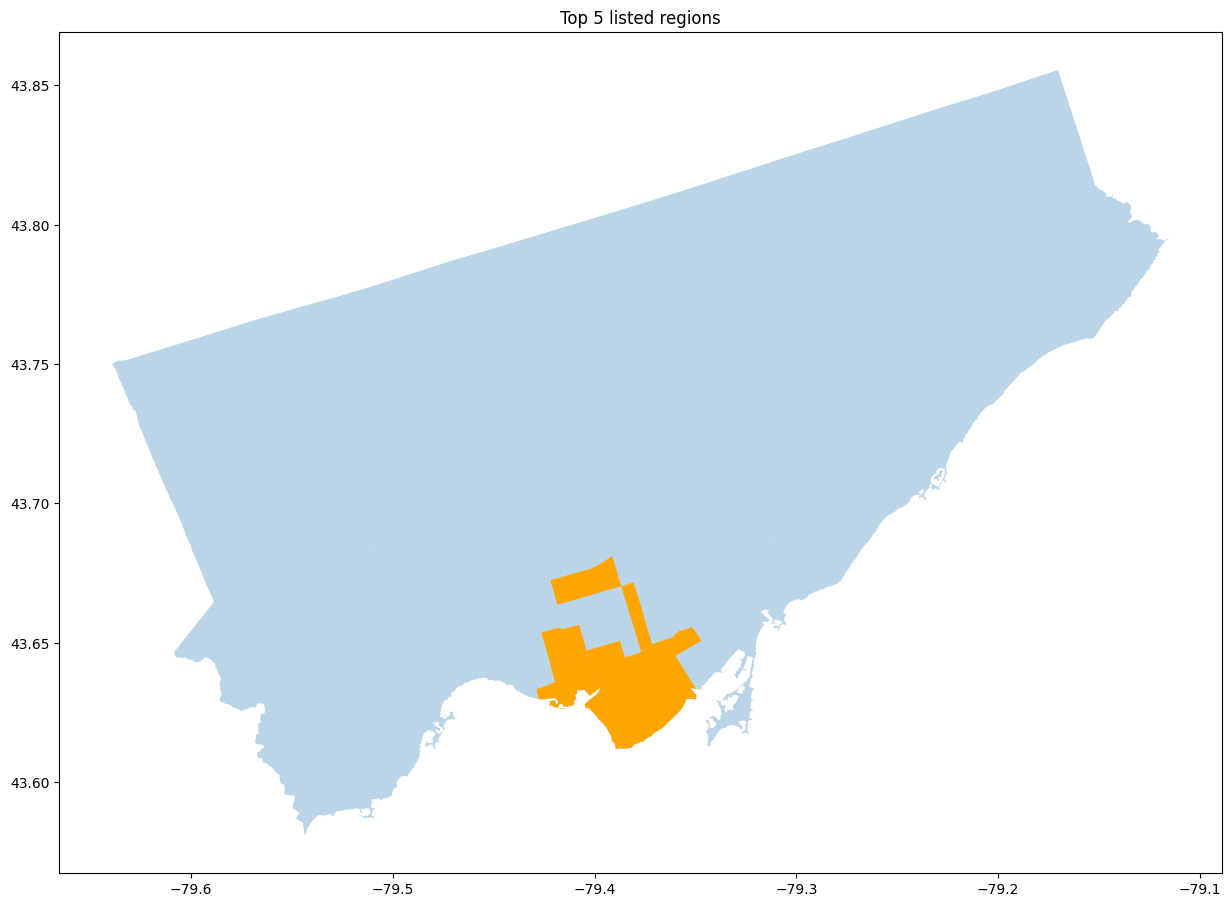

In [122]:
# Find the top 5 neighbourhoods that have the most number of listings
top_five_listing_regions = geo_df.groupby('neighbourhood').count().sort_values('id', ascending=False).head(5).index.tolist()
fig, ax = plt.subplots(figsize = (15,15))
neighbourhoods_json.plot(ax = ax, alpha = 0.3)
neighbourhoods_json[neighbourhoods_json['neighbourhood'].isin(top_five_listing_regions)].plot(ax = ax, color = 'orange')
plt.title('Top 5 listed regions')

Text(0.5, 1.0, 'Number of listings by region')

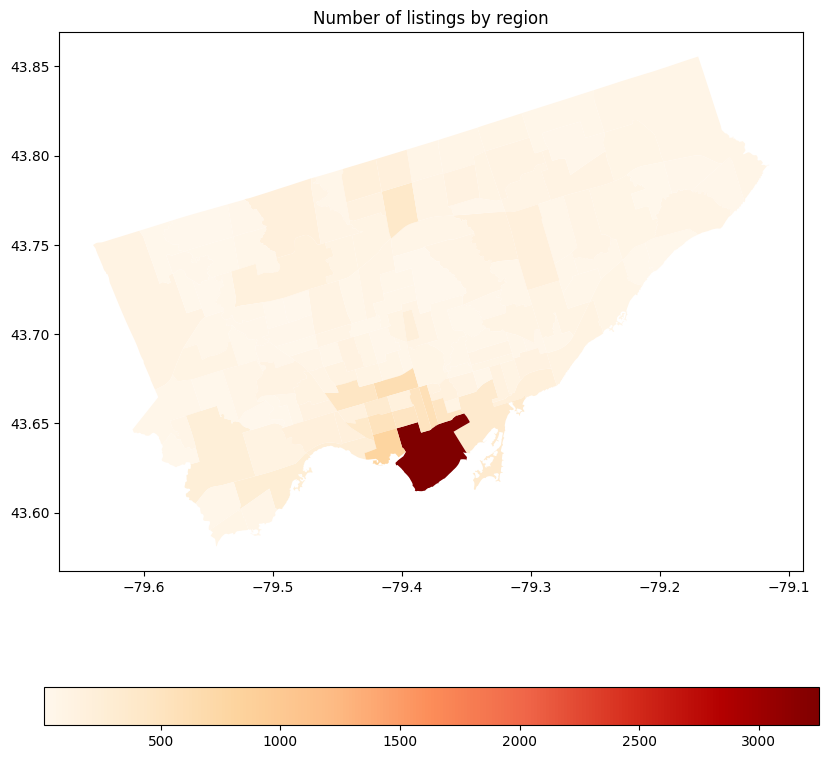

In [123]:
listings_by_region = geo_df[['neighbourhood', 'id']].groupby('neighbourhood').count()
listings_by_region = pd.merge(neighbourhoods_json, listings_by_region, left_on = 'neighbourhood', right_index = True)
fig, ax = plt.subplots(figsize = (10, 10))
listings_by_region.plot(ax = ax, column = 'id', cmap='OrRd', legend = True, legend_kwds= {'orientation': 'horizontal'})
plt.title('Number of listings by region')

Text(0.5, 1.0, 'Top 5 most expensive regions')

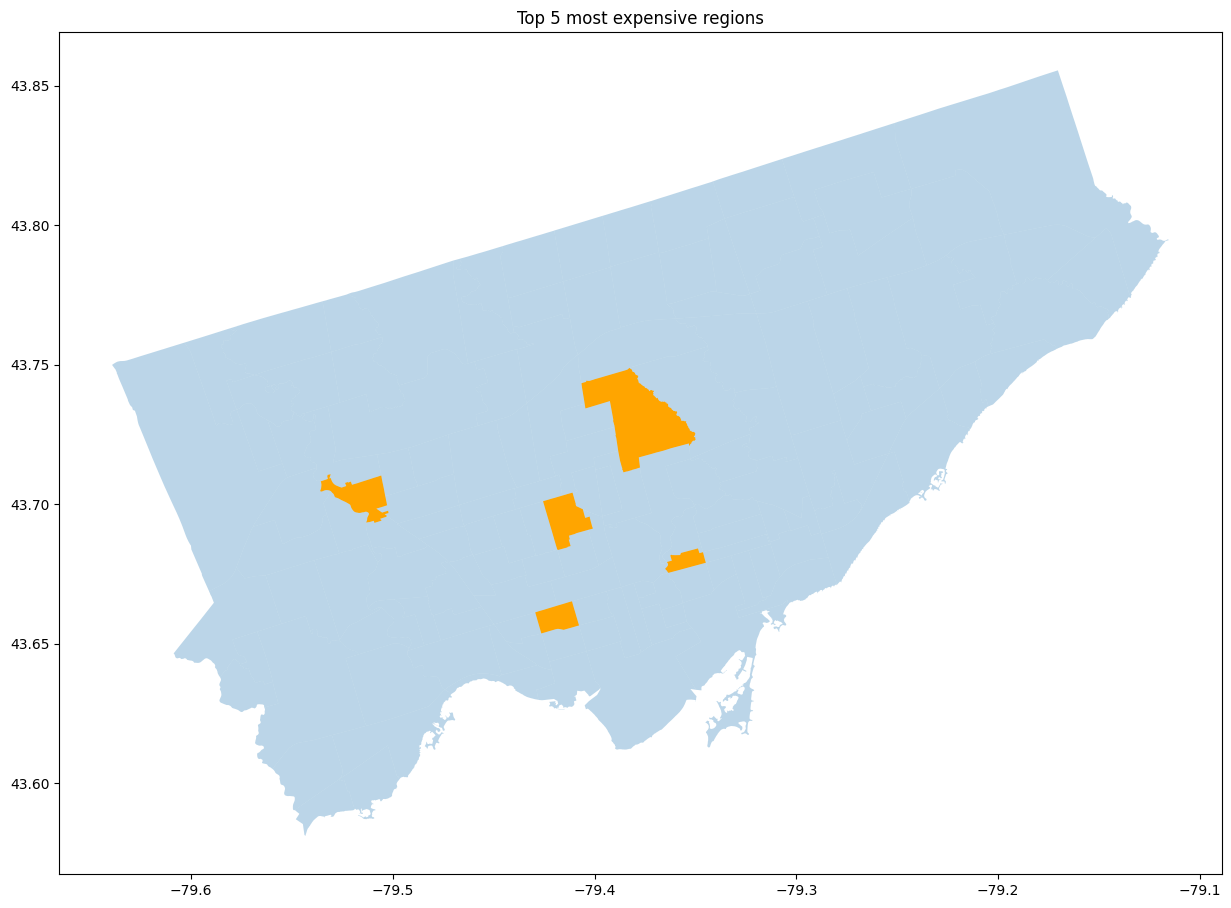

In [124]:
# Find top 5 neighbourhoods with the most expensive average prices
top_five_price_regions = geo_df[['neighbourhood', 'price']].groupby(['neighbourhood']).mean().sort_values(by = 'price', ascending = False).head(5).index.tolist()

fig, ax = plt.subplots(figsize = (15,15))
neighbourhoods_json.plot(ax = ax, alpha = 0.3)
neighbourhoods_json[neighbourhoods_json['neighbourhood'].isin(top_five_price_regions)].plot(ax = ax, color = 'orange')
plt.title('Top 5 most expensive regions')

Text(0.5, 1.0, 'Average price per region')

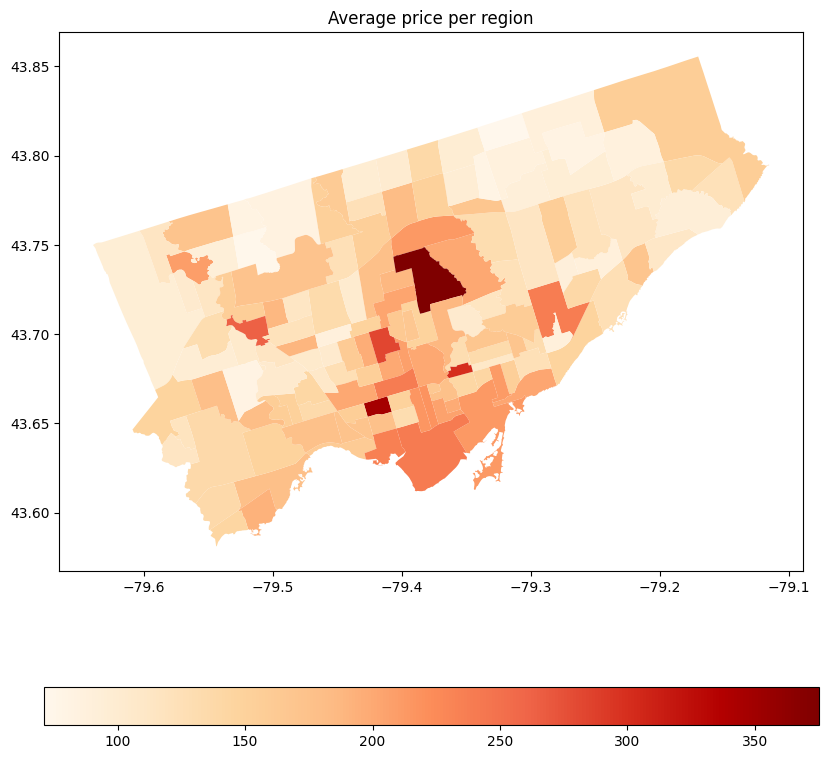

In [125]:
average_price_by_region = geo_df[['neighbourhood', 'price']].groupby('neighbourhood').mean()
average_price_by_region = pd.merge(neighbourhoods_json, average_price_by_region, left_on = 'neighbourhood', right_index = True)
fig, ax = plt.subplots(figsize = (10, 10))
average_price_by_region.plot(ax = ax, column = 'price', cmap='OrRd', legend = True, legend_kwds= {'orientation': 'horizontal'})
plt.title('Average price per region')

Text(0.5, 1.0, 'Mean ratings by region')

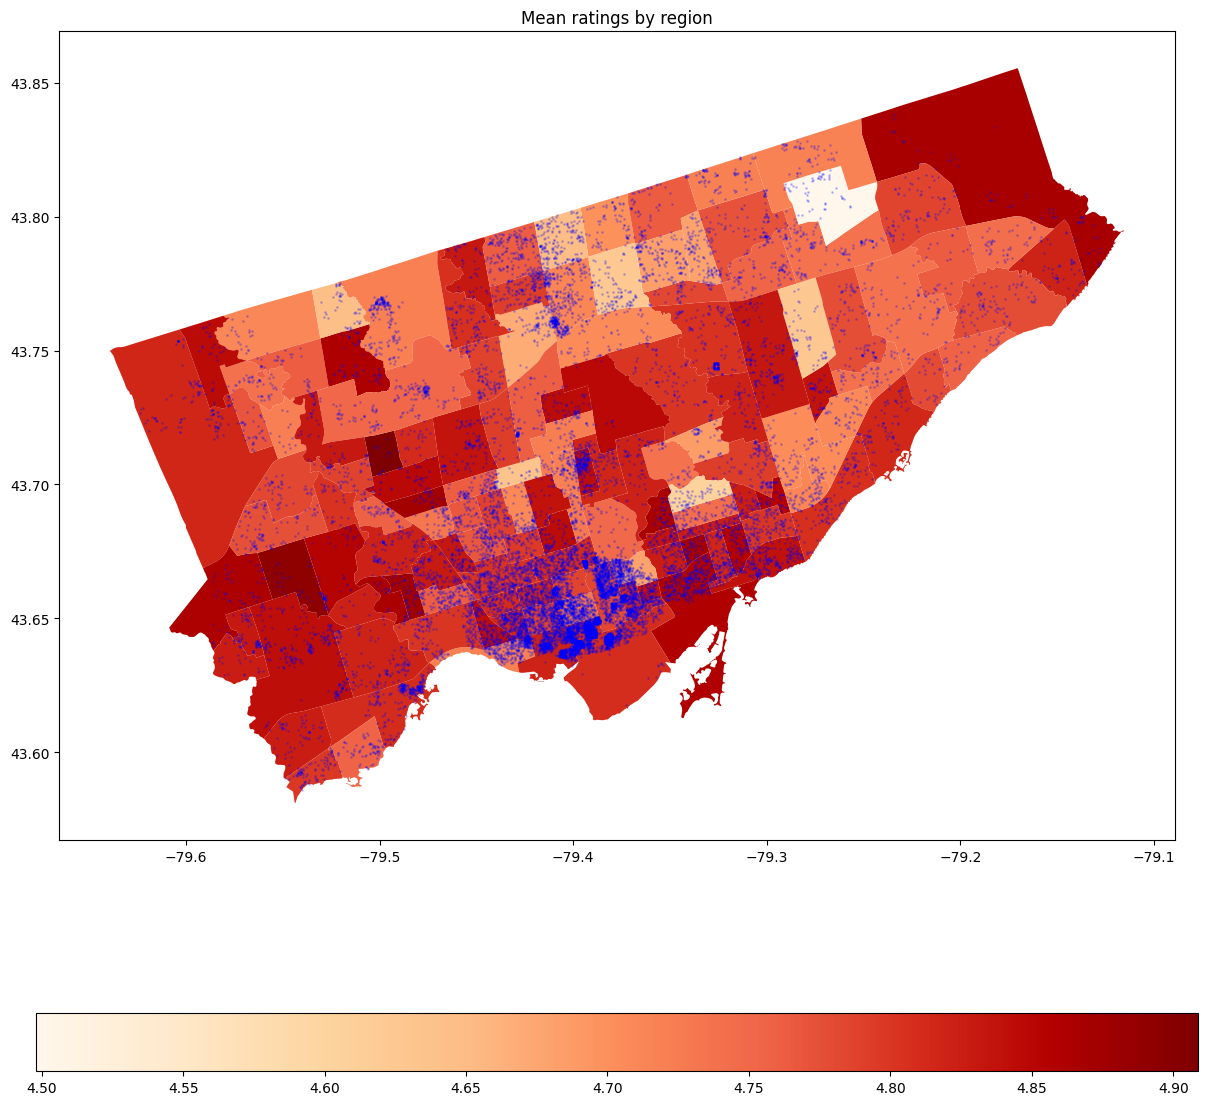

In [126]:
ratings_by_region = geo_df[['neighbourhood', 'ratings']].groupby('neighbourhood').mean()
ratings_by_region = pd.merge(neighbourhoods_json, ratings_by_region, left_on = 'neighbourhood', right_index = True)
fig, ax = plt.subplots(figsize = (15, 15))
ratings_by_region.plot(ax = ax, column = 'ratings', cmap='OrRd', legend = True, legend_kwds= {'orientation': 'horizontal'})
geo_df.plot(ax = ax, color = 'blue', markersize = 1, alpha = 0.2)
plt.title('Mean ratings by region')

Text(0, 0.5, 'Average price')

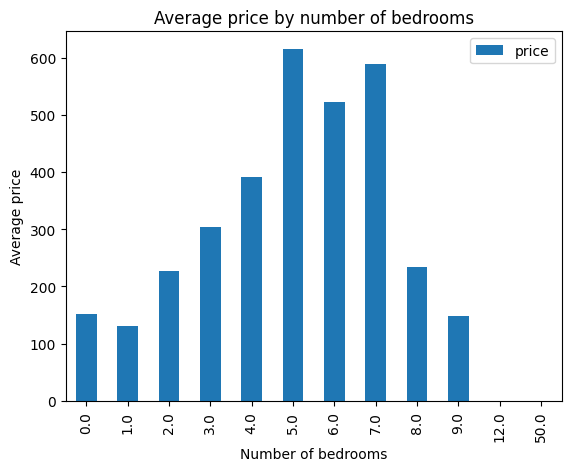

In [127]:
geo_df[['bedrooms', 'price']].groupby('bedrooms').mean().plot.bar()
plt.title('Average price by number of bedrooms')
plt.xlabel('Number of bedrooms')
plt.ylabel('Average price')

Text(0, 0.5, 'Average price')

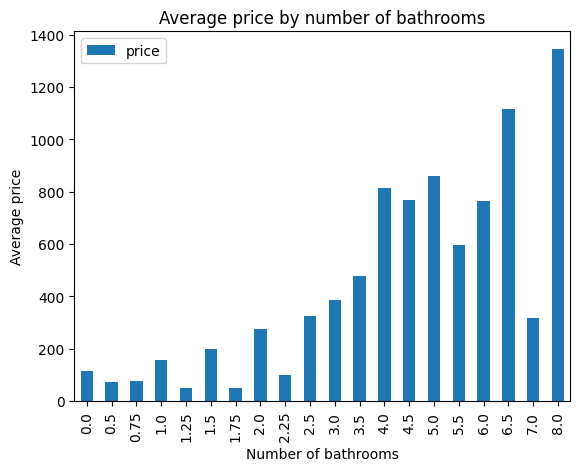

In [128]:
geo_df[['bathrooms', 'price']].groupby('bathrooms').mean().plot.bar()
plt.title('Average price by number of bathrooms')
plt.xlabel('Number of bathrooms')
plt.ylabel('Average price')

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
<ipython-input-129-cd0c4cb0a366>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ratings_df[['ratings_group', 'price']].groupby('ratings_group').mean().plot.bar()


Text(0, 0.5, 'Average price')

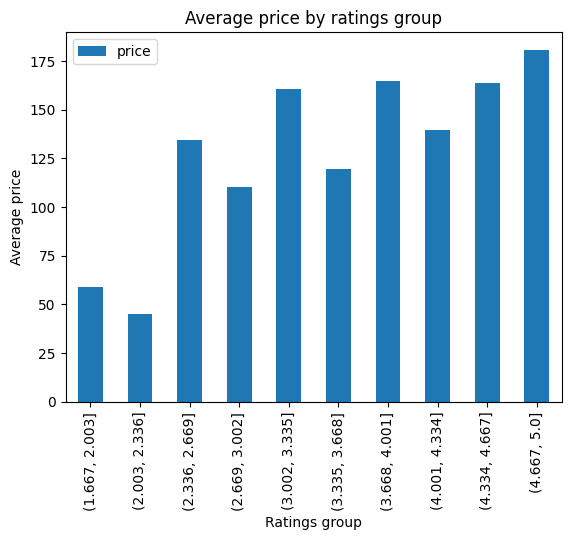

In [129]:
ratings_df = geo_df[~geo_df['ratings'].isnull()]
ratings_df['ratings_group'] = pd.cut(ratings_df['ratings'], bins = 10)
ratings_df[['ratings_group', 'price']].groupby('ratings_group').mean().plot.bar()
plt.title('Average price by ratings group')
plt.xlabel('Ratings group')
plt.ylabel('Average price')

Text(0, 0.5, 'Average price')

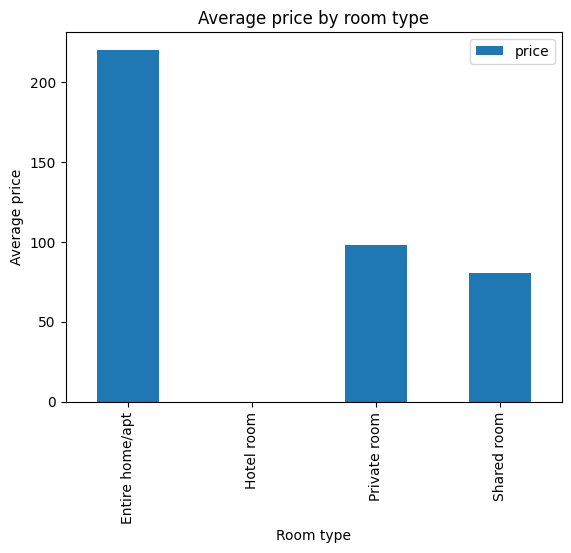

In [130]:
geo_df[['room_type', 'price']].groupby('room_type').mean().plot.bar()
plt.title('Average price by room type')
plt.xlabel('Room type')
plt.ylabel('Average price')

<Axes: >

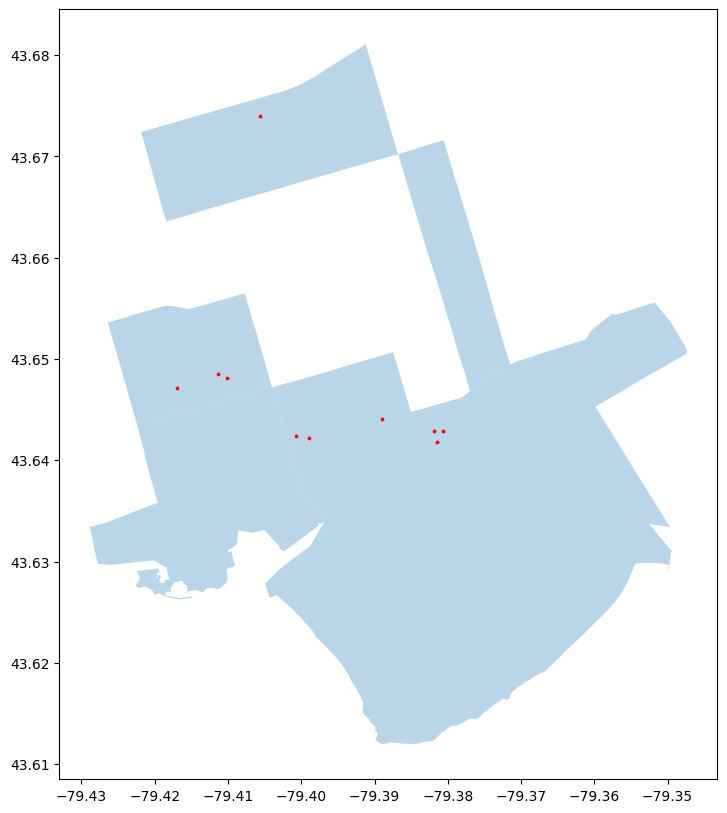

In [131]:
# Apply conditions to look for desired listings, and show them on the map
condition_one = geo_df['ratings'] > 4.9
condition_two = geo_df['number_of_reviews'] > 150
condition_three = geo_df['bedrooms'] >= 2
condition_four = geo_df['neighbourhood'].isin(['Niagara', 'Waterfront Communities-The Island', 'Annex', 'Church-Yonge Corridor', 'Trinity-Bellwoods'])
condition_five = geo_df['price'] < 300

fig, ax = plt.subplots(figsize = (10, 10))
neighbourhoods_json[neighbourhoods_json['neighbourhood'].isin(['Niagara', 'Waterfront Communities-The Island', 'Annex', 'Church-Yonge Corridor', 'Trinity-Bellwoods'])].plot(ax = ax, alpha = 0.3)
geo_df[condition_one & condition_two & condition_three & condition_four & condition_five].plot(ax = ax, color = 'red', markersize = 3)

In [132]:
# Show samples of the result
geo_df[condition_one & condition_two & condition_three & condition_four & condition_five].head()

,id,name,host_id,host_name,neighbourhood,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license,geometry,bathrooms,bedrooms,ratings
2042,13083421,Rental unit in Toronto · ★4.99 · 3 bedrooms · ...,72249424,Debbie,Trinity-Bellwoods,Entire home/apt,242.0,28,157,2023-09-10,1.70,1,265,3,NaN,POINT (-79.41699 43.64715),2.0,3.0,4.99
2896,17302790,Home in Toronto · ★4.98 · 2 bedrooms · 2 beds ...,111388855,Erin,Trinity-Bellwoods,Entire home/apt,297.0,28,259,2023-08-08,3.12,1,76,1,STR-2011-HXQKVL,POINT (-79.41132 43.64852),1.0,2.0,4.98
2988,17794236,Condo in Toronto · ★4.91 · 3 bedrooms · 3 beds...,120006793,Robert,Waterfront Communities-The Island,Entire home/apt,129.0,1,330,2024-01-02,4.00,1,0,42,STR-2304-FPMBHQ,POINT (-79.38186 43.64285),2.0,3.0,4.91
3083,18377465,Condo in Toronto · ★4.96 · 2 bedrooms · 2 beds...,127276512,Lyudmila,Waterfront Communities-The Island,Entire home/apt,150.0,28,168,2023-10-01,2.11,2,199,67,STR-2209-GCZXVF,POINT (-79.38144 43.64180),1.5,2.0,4.96
3230,19033422,Home in Toronto · ★4.91 · 2 bedrooms · 2 beds ...,12766664,David,Trinity-Bellwoods,Entire home/apt,218.0,2,280,2023-12-31,3.56,1,87,43,STR-2009-HSDPBL,POINT (-79.41020 43.64815),1.0,2.0,4.91
